# Agenda
This notebook demonstrates two use cases. The first use case is finetuning.
(a) In this case we load a model with weights and fine tune it to our application by training it further.
(b) The second use case is to use a pretrained model as it is to get embeddings as a feature extractor.
We can freeze most of the layers and train the last layer to fit our needs

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Download data and create dataset/dataloaders
Download the dataset and put it in hymenoptera_data and create datasets with the transforms below.
The transforms are creating 224x224 images based on RandomCrop and train is also doing random horizontal
flip. Validation is doing a resize to ensure image is at least 256x256 before crop

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Resclae and display image
We get inputs and classes by calling the iterator on the dataset.
Later we glew them into a single image based on one batch. This is
done by calling torchvision.utils.make_grid . Later we have a utility
function that is taking in the combined image and also list of class
labels and the image is simply rescaled and shown. Rescaling is needed
because the transforms (in dataset/dataloader) are normalizing the input.

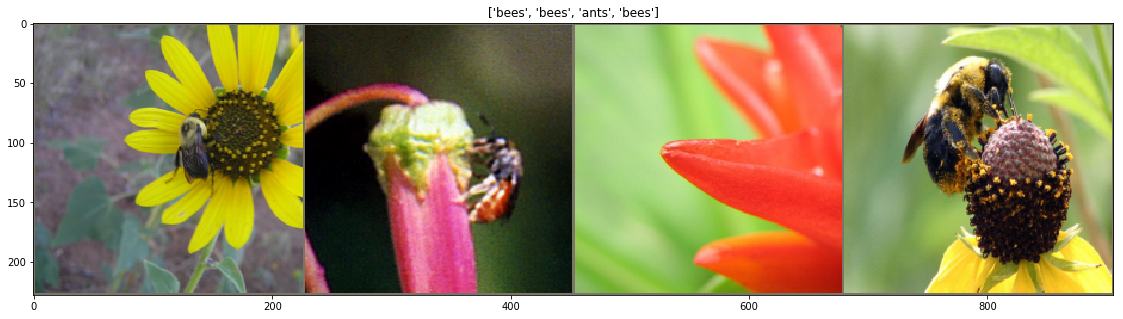

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,5))
    plt.imshow(inp) #, aspect='auto')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Define an evaluation function
We define an evaluation function. 
We also use it by importing resnet18 and tweaking its last layer to be a 2 dim classifier to suit our need 

In [53]:
def eval_model(model):
    tot = 0
    correct = 0
    for inputs, labels in iter(dataloaders['train']):
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) * inputs.size(0)
            tot += outputs.shape[0]
            correct += torch.sum(preds == labels.data)
    return correct, tot, loss

Before making changes to ResNet, we show its architecture here and in the next cell
we would be changing its last layer to output 2 nodes

In [56]:
m1 = models.resnet18(pretrained=True)
m1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Import ResNet and adopt to suit our needs. Instead of 1000 class classification we make it a binary classifier

In [55]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

correct, tot, loss = eval_model(model)
acc = 100.0*correct/float(tot)
avg_loss = loss / float(tot)
print ("Evaluation on resnet19 pretrained, accuracy = {}, avg_loss = {}, loss = {}".format(acc, avg_loss, loss))

Evaluation on resnet19 pretrained, accuracy = 54, avg_loss = 0.00835235975683, loss = 2.03797578812


## Train model function
We implement a function to train the model. model, criterion(loss function), optimizer and
scheduler. epochs are passed as arguments. Training will run for num_epochs and in every epoch, it
trains the model and runs validaiton. If validation error is better than best accuracy, then best_model_wts
is updated. In the end the best value for best_model_wts is set to the model. In theory we don't make the model any worse if we can rely on validation set.

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 # Ideally this should be initialized as accuracy on validation set

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualize model
In this section, we iterate through the datset until we score num_images.
For every image we show the image and also the predicted label.

In [44]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Load a model and retrain
We load ReseNet18 and replace the last layer with 2 dim linear and define a criterion(crossEntropyLoss)
and also define an SGD instance. A scheduler is also added that will decay the learning rate after every 7 epochs.

In [45]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/jaisongeorge/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:13<00:00, 3383969.83it/s]


In [46]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6942 Acc: 0.6557
val Loss: 0.2568 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4510 Acc: 0.8156
val Loss: 0.4068 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.3477 Acc: 0.8648
val Loss: 0.3345 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5138 Acc: 0.8074
val Loss: 0.2222 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5417 Acc: 0.7951
val Loss: 0.2654 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4481 Acc: 0.8402
val Loss: 0.5401 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.3752 Acc: 0.8566
val Loss: 0.2189 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4071 Acc: 0.8279
val Loss: 0.2055 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3297 Acc: 0.8730
val Loss: 0.1914 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2884 Acc: 0.8566
val Loss: 0.2021 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2897 Acc: 0.8607
val Loss: 0.2145 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.1971 Acc: 0.9098
val Loss: 0.2037 Acc: 0.9216

Ep

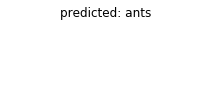

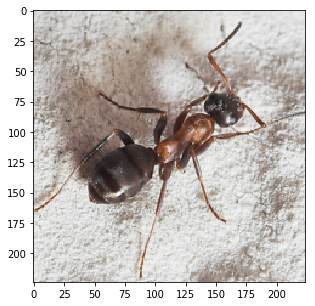

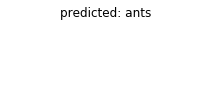

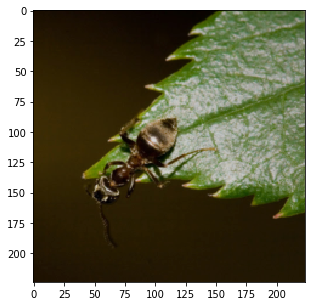

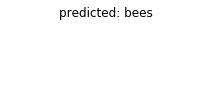

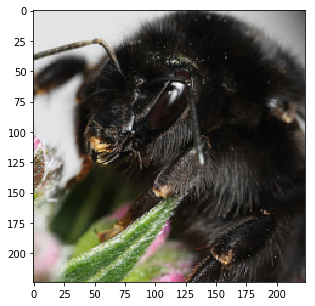

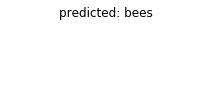

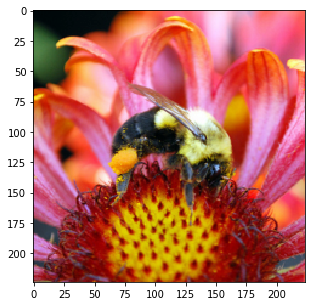

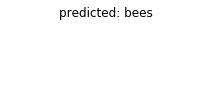

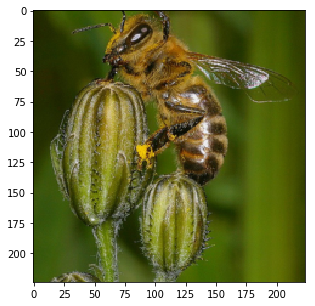

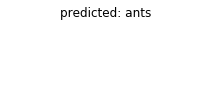

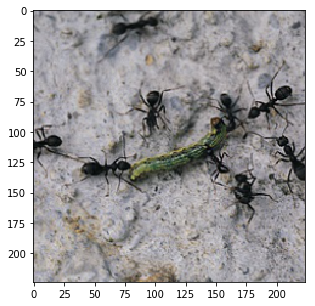

In [47]:
visualize_model(model_ft)

## Freeze layers and then train the same model
We do the exact same thing as previous with one minor modification. We freeze all the layers
of the model except one so that the model now acts as a feature extractor for the msot part.
We retrain last layer to suit our needs. All the code and functions we wrote earlier are still
useful and feezing layers is done by a simple flag.

In [49]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5833 Acc: 0.6721
val Loss: 0.2283 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.7071 Acc: 0.7090
val Loss: 0.3637 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.5113 Acc: 0.7746
val Loss: 0.1697 Acc: 0.9673

Epoch 3/24
----------
train Loss: 0.5284 Acc: 0.7869
val Loss: 0.2275 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3748 Acc: 0.8279
val Loss: 0.1901 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4151 Acc: 0.8238
val Loss: 0.1863 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3656 Acc: 0.8238
val Loss: 0.2148 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3647 Acc: 0.8525
val Loss: 0.1884 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3520 Acc: 0.8443
val Loss: 0.1820 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3771 Acc: 0.8484
val Loss: 0.1924 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4066 Acc: 0.7869
val Loss: 0.1943 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3304 Acc: 0.8443
val Loss: 0.1892 Acc: 0.9216

Ep

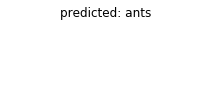

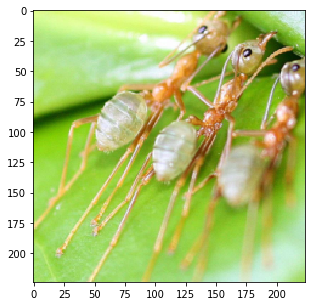

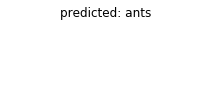

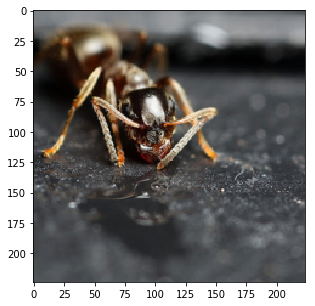

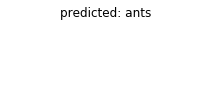

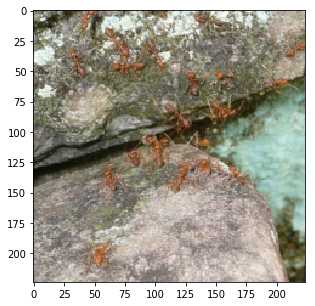

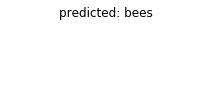

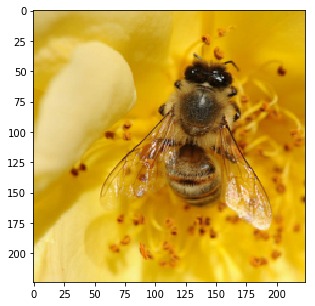

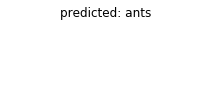

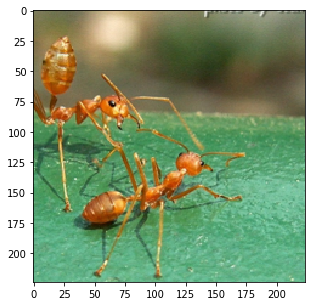

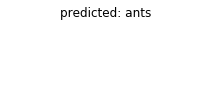

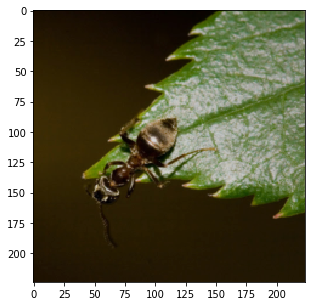

In [51]:
visualize_model(model_conv)

plt.ioff()
plt.show()